In [1]:
import sys
import os.path

import numpy as np
from numpy import sqrt, exp, pi
from scipy.special import erf
import matplotlib.pyplot as plt

import pyfvtool as pf

In [2]:
print('Python: ', sys.version)
print('PyFVTool: ', pf.__version__)

Python:  3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:37:18) [MSC v.1943 64 bit (AMD64)]
PyFVTool:  0.3.5


# Diffusion of an initial sphere into an infinite medium

M.H.V. Werts, 2020, 2024

Here, we study the diffusion equation in an infinite medium with the initial condition that all matter is homogeneously distributed in a sphere radius $a$, and no matter is outside of this sphere.

**Reference:** J. Crank (1975) "The Mathematics of Diffusion", 2nd Ed., 
      Clarendon Press (Oxford), pages 29-30, Equation 3.8, Figure 3.1

A system of spherical symmetry in a spherical coordinate system, *i.e.* "1D spherical", space coordinate $r$. Time $t$.

System parameters:

$a$ : radius of initial sphere; 
$c_0$ : concentration in initial sphere; 
$D$ : diffusion coefficient

Simple diffusion equation:

$$\frac{\partial c}{\partial t} = D \nabla^2 c$$

with initial condition:

$$ 
c(t = 0, r \leqslant a) = c_0 \quad \\ 
c(t = 0, r > a) = 0
$$



In [3]:
a = 1.0
C_0 = 1.0
D_val = 1.0

# Analytic solution

From Crank's "Mathematics of Diffusion" (2nd Ed., 1975), Chapter 3, we take Eqn 3.8 and Fig. 3.1.

Crank's Eqn 3.8 is coded below as the function ``C_sphere_infmed(r, t, a, D)``

In [4]:
# this evaluates Crank (1975), eqn. (3.8)

def C_sphere_infmed(r, t, a, D):
    term1 = erf((a-r)/(2*sqrt(D*t))) + erf((a+r)/(2*sqrt(D*t)))
    term2b = exp(-(a-r)**2/(4*D*t)) - exp(-(a+r)**2/(4*D*t))
    term2a = (D*t/pi) 
    C = 0.5 * C_0 * term1 - C_0/r * sqrt(term2a) * term2b
    return C

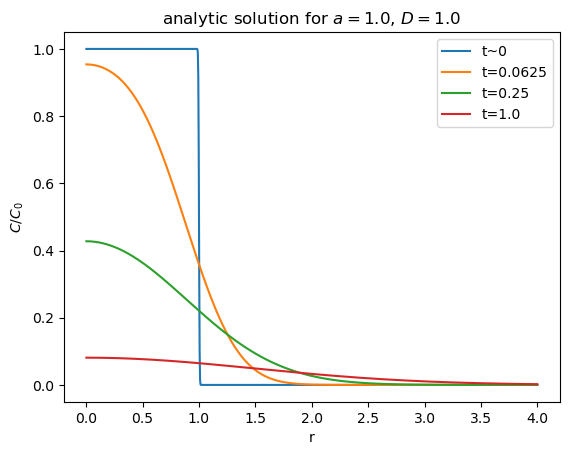

In [5]:
rr = np.linspace(0.001,4,1000)
plt.figure(2)
plt.clf()
plt.title(f'analytic solution for $a = {a}$, $D = {D_val}$')
plt.plot(rr, C_sphere_infmed(rr, 0.00001, a, D_val), label='t~0')
plt.plot(rr, C_sphere_infmed(rr, 0.0625, a, D_val), label='t=0.0625')
plt.plot(rr, C_sphere_infmed(rr, 0.25, a, D_val), label='t=0.25')
plt.plot(rr, C_sphere_infmed(rr, 1.0, a, D_val), label='t=1.0')
plt.ylabel('$C / C_0$')
plt.xlabel('r')
plt.legend();

The figure above is consistent with Figure 3.1 from Crank's book, demonstrating probable correctness of our code for evaluation of the analytic solution.

# Comparison with numerical solution by PyFVTool

Now we will reproduce the curves at the different time points using PyFVTool. 

It was observed that a very fine grid needs to be used. 50 cells is woofully insufficient (very imprecise result), 100 is slightly better, 500 seems to do OK, 1000 cells on 10 units width better still. We finally used 2000 cells over 10 length units. We use small time-steps (0.0625/20 instead of 0.0625/10), but this does not change the final result much.

In [6]:
## Define the domain and create a mesh structure
# Here we work in a 1D spherical coordinate system (r coordinate)
R = 10.0   # domain radius (this models an infinite medium)
Nr = 2000  # number of cells
m = pf.SphericalGrid1D(Nr, R)

In [7]:
D = pf.CellVariable(m, D_val)
alfa = pf.CellVariable(m, 1.0)

In [8]:
c_fvm = pf.CellVariable(m, 0)
r_fvm = c_fvm.cellcenters.r
c_fvm.value[r_fvm < a] = C_0

In [9]:
# Implicit 'no-flux' boundary conditions (Neumann)
# TO DO: in this case, it should not change much if we switch to Dirichlet

In [10]:
t = 0.0 # total time
deltat = 0.0625/20 # time step

# output total mass in the system
print(0, t, c_fvm.domainIntegral())

# store initial condition in list
pyfvtool_c = [c_fvm.value]

0 0.0 4.188764024847613


In [11]:
## loop for "time-stepping" the solution
# It outputs the spatial profile C(r) after
# 20, 80 and 320 time-steps
# This corresponds to t=0.0625, t=0.25 and t=1, respectively.
for sdi in [20,60,240]:
    for n in range(sdi):
        transientterm = pf.transientTerm(c_fvm, deltat, alfa)
        Dave = pf.harmonicMean(D)
        diffusionterm = pf.diffusionTerm(Dave)
        pf.solvePDE(c_fvm, [ transientterm,
                            -diffusionterm])
        t += deltat

    print(0, t, c_fvm.domainIntegral())
    pyfvtool_c.append(c_fvm.value)

0 0.06250000000000001 4.188767980524447
0 0.2499999999999996 4.188778049013295
0 1.0000000000000058 4.188786238173347


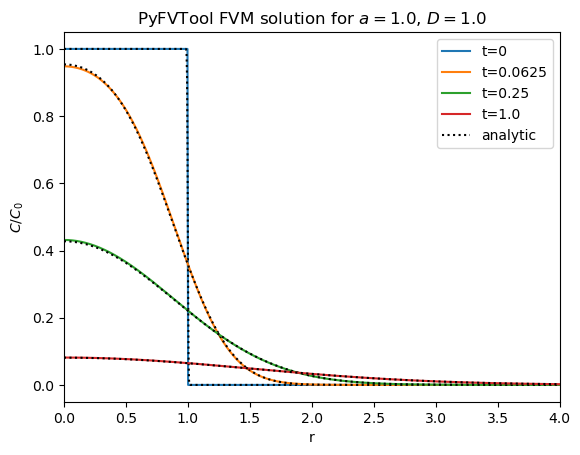

In [12]:
rr = np.linspace(0.001,4,1000)
plt.figure(2)
plt.clf()
plt.title(f'PyFVTool FVM solution for $a = {a}$, $D = {D_val}$')
plt.plot(r_fvm, pyfvtool_c[0], label='t=0')
plt.plot(rr, C_sphere_infmed(rr, 0.00001, a, D_val), 'k:')
plt.plot(r_fvm, pyfvtool_c[1], label='t=0.0625')
plt.plot(rr, C_sphere_infmed(rr, 0.0625, a, D_val), 'k:')
plt.plot(r_fvm, pyfvtool_c[2], label='t=0.25')
plt.plot(rr, C_sphere_infmed(rr, 0.25, a, D_val), 'k:')
plt.plot(r_fvm, pyfvtool_c[3], label='t=1.0')
plt.plot(rr, C_sphere_infmed(rr, 1.0, a, D_val), 'k:', label = 'analytic')
plt.ylabel('$C / C_0$')
plt.xlabel('r')
plt.xlim(0, 4)
plt.legend();

In [13]:
# time hard-coded for now (t = 1.0)
fvmdiff = pyfvtool_c[3] - C_sphere_infmed(r_fvm, 1.0, a, D_val)

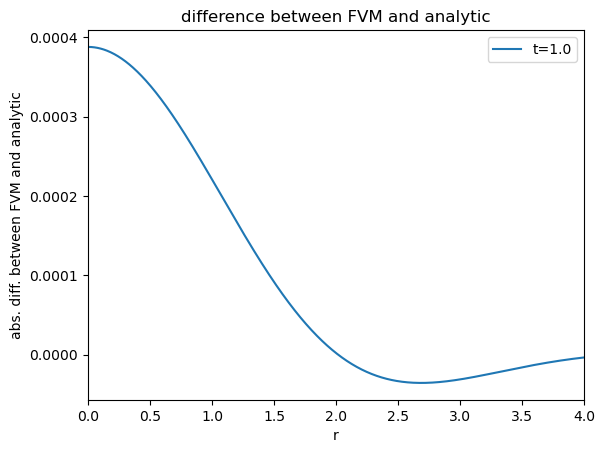

In [14]:
plt.figure(3)
plt.clf()
plt.title('difference between FVM and analytic')
plt.plot(r_fvm, fvmdiff, label='t=1.0')
plt.ylabel('abs. diff. between FVM and analytic')
plt.xlabel('r')
plt.xlim(0, 4)
plt.legend();

# Conclusion

This notebook shows that once the computational parameters PyFVTool have suitable values, close agreement is obtained with the analytic solution from [Crank 1975] for this particular diffusion problem. It also shows how to how to set up a simple calculation in spherical symmetry with PyFVtool.

It might be of interest to analyze the subtle differences between the analytic and numerical solutions. The PyFVTool calculation may be made more efficient by using unevenly sized cells: smaller cells near the initial sphere, larger cells farther away from the origin.